# ANDI 2020 submission: from trajectories to predictions

In this notebook we will explore how to make predictions from the trajectories we have access to in the [ANDI challenge](https://github.com/AnDiChallenge/ANDI_datasets). From this trajectories, I will showcase the use of the tMSD method for Task 1 and a novel ML method for Task 2. Task 3 is a combination of the two previous and will not be explored in this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

The best way of dealing with the available datasets is by means of the `andi-datasets` python package, which can be installed using `pip install andi-datasets`. Then, the dataset can be created from the function `challenge_2020_dataset`, allocated in the `datasets_theory` module.

In [ ]:
from andi_datasets.datasets_theory import datasets_theory
MT = datasets_theory()

For this tutorial, I have first downloaded the datasets available in the Challenge webpage (www.andi-challenge.org). Note that you need to register before being able to access the data. You will have access to two datasets, one for training, which is labeled, and one for scoring, which is used to rank the participants in the competition. In this case, I downloaded each of the datasets in the following folders:

In [ ]:
path_datasets = 'datasets/'

To load the training dataset, we only need to do:

In [ ]:
X1, Y1, X2, Y2, X3, Y3 = MT.challenge_2020_dataset(load_dataset = True, path_datasets = path_datasets)

Creating a dataset for task(s) [1, 2, 3] and dimension(s) [1, 2, 3].


In the case you are working with a validation dataset, and do not have the labels (in this case stored in the files `refX.txt`), you can use the optional parameter `load_labels = False`, as follows:

In [ ]:
validation = MT.challenge_2020_dataset(load_dataset = True, path_datasets = path_datasets, load_labels = False)

Creating a dataset for task(s) [1, 2, 3] and dimension(s) [1, 2, 3].


# Task 1 - Anomalous exponent prediction

`X1` contains the trajectories for task 1. As we asked for all dimensions, `X1` will be a list of three elements, each element one dimension. The same for the labels `Y1`. Let us check the 1D case:

In [ ]:
X1_1D = X1[0] 
Y1_1D = Y1[0]

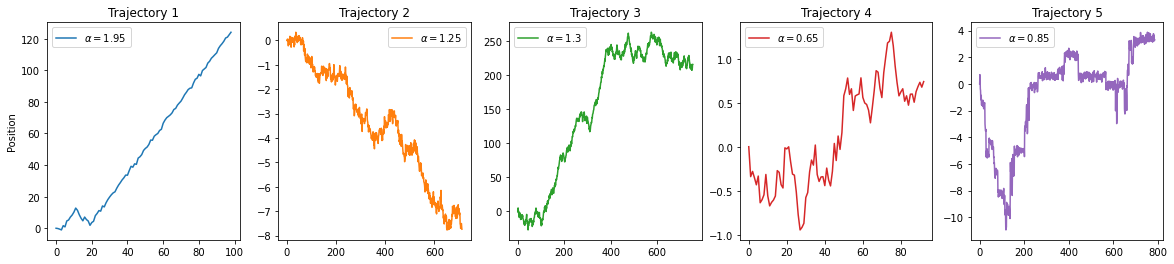

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for idx, (t, l) in enumerate(zip(X1_1D[:5], Y1_1D[:5])):
    ax[idx].plot(t, label = r'$\alpha =$'+str(l), c = 'C'+str(idx))
    ax[idx].legend()
    ax[idx].set_title(f'Trajectory {idx+1}')
ax[0].set_ylabel('Position');

## The 'good old' way: the tMSD fitting

One way to extract the anomalous exponent is by fitting the tMSD:
$$
\mbox{tMSD}(\Delta) = \frac{1}{T-\Delta} \sum_{i=1}^{T-\Delta}(x(t_i + \Delta)-x(t_i))^2,
$$
where $\Delta$ is defined as the time lag and $T$ is length of the trajectory.

In [ ]:
def TMSD(traj, t_lags):
    ttt = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags): 
        for p in range(len(traj)-t):
            ttt[idx] += (traj[p]-traj[p+t])**2            
        ttt[idx] /= len(traj)-t    
    return ttt

We know that (usually) $$\mbox{tMSD}(\Delta) \sim \Delta ^ \alpha,$$ hence we can use it to extract the anomalous exponent. Let us check this on trajectories from two models: ATTM and FBM. For that we can again use the `andi` package, and access the diffusion models directly:

In [ ]:
from andi.models_theory import models_theory
MT = models_theory()

# We create one ATTM and one FBM trajectory with alpha = 0.2
attm = MT._oneD().attm(T = 1000, alpha = 0.2)
fbm = MT._oneD().fbm(T = 1000, alpha = 0.2)

# We calculate their tMSD
t_lags = np.arange(2, 20)
attm_tmsd = TMSD(attm, t_lags = t_lags)
fbm_tmsd = TMSD(fbm, t_lags = t_lags)

Let's plot the tMSD:

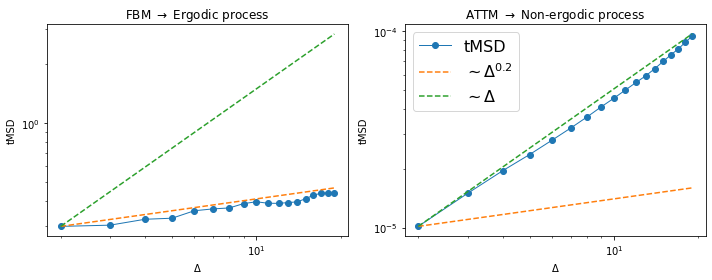

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10, 4))

ax[0].loglog(t_lags, fbm_tmsd, '-o', lw = 1)
ax[0].loglog(t_lags, t_lags**0.2/(t_lags[0]**0.2)*fbm_tmsd[0], ls = '--')
ax[0].loglog(t_lags, t_lags/(t_lags[0])*fbm_tmsd[0], ls = '--')
ax[0].set_title(r'FBM $\rightarrow$ Ergodic process')

ax[1].loglog(t_lags, attm_tmsd, '-o', lw = 1,label = 'tMSD')
ax[1].loglog(t_lags, t_lags**0.2/(t_lags[0]**0.2)*attm_tmsd[0], ls = '--', label = r'$\sim \Delta^{0.2}$')
ax[1].loglog(t_lags, t_lags/(t_lags[0])*attm_tmsd[0], ls = '--', label = r'$\sim \Delta$')
ax[1].set_title(r'ATTM $\rightarrow$ Non-ergodic process')
ax[1].legend(fontsize = 16)

plt.setp(ax, xlabel = r'$\Delta$', ylabel = 'tMSD');
fig.tight_layout()


We see that the tMSD works very well for ergodic processes, but fails horribly for non-ergodic, for which we usually have that $tMSD\sim\Delta$. Nevertheless, let's use it to fit the exponent of the 1D training dataset:

In [ ]:
t_lags = np.arange(2,10)
predictions = []

for traj in X1[0]:
    tmsd = TMSD(traj, t_lags)
    predictions.append(np.polyfit(np.log(t_lags), np.log(tmsd),1)[0])
    
print('MAE = '+str(np.round(np.mean(np.abs(np.array(predictions)-Y1[0])), 4)))

MAE = 0.3342


Let's see how is the error distributed:

Text(0, 0.5, 'Frequency')

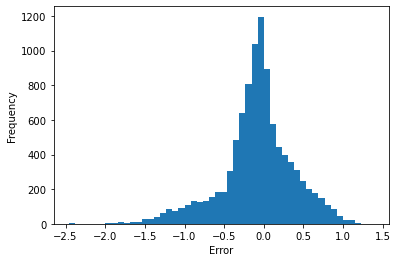

In [ ]:
plt.hist(np.array(predictions)-Y1[0], bins = 50);
plt.xlabel('Error')
plt.ylabel('Frequency')

We can now use the same method to predict the exponent of the validation dataset `V1`, for **1D**

In [ ]:
t_lags = np.arange(1,10)
predictions_task1_1d = []

for traj in validation[0][0]:
    tmsd = TMSD(traj, t_lags)
    predictions_task1_1d.append(np.polyfit(np.log(t_lags), np.log(tmsd),1)[0])

To make a submission, you only need to write a .txt file for which:
- The name is the task: task1.txt, task2.txt, task3.txt
- The first column is the dimension (1,2 or 3)
- The following columns are the results
- Delimiter should be ;

In [ ]:
pred_to_txt = np.ones((len(predictions_task1_1d), 2))
pred_to_txt[:, 1] = predictions_task1_1d

np.savetxt('task1.txt', pred_to_txt.astype(float), fmt = '%1.5f', delimiter = ';')

### Then, we zip it and submit!

# Task 2 - Model classification

Let's check the trajectory for the second task. The structure of the variables `X2` and `Y2` is just as we explained for the first task. We will focus again in 1D:

In [ ]:
X2_1D = X2[0] 
Y2_1D = Y2[0]

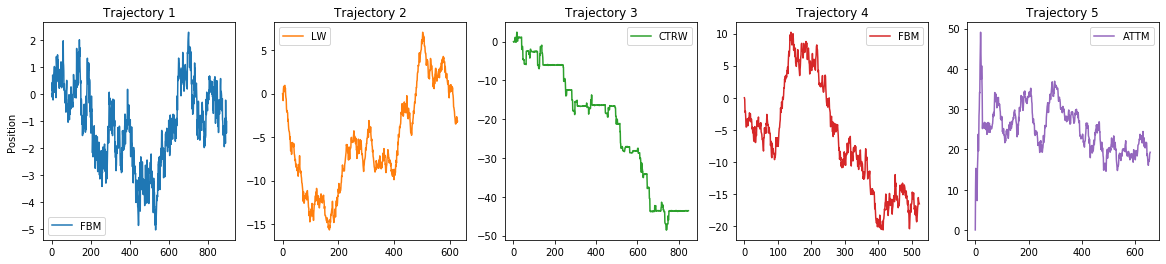

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for idx, (t, l) in enumerate(zip(X2_1D[:5], Y2_1D[:5])):
    ax[idx].plot(t, label = AD().avail_models_name[int(l)].upper(), c = 'C'+str(idx))
    ax[idx].legend()
    ax[idx].set_title(f'Trajectory {idx+1}')
ax[0].set_ylabel('Position');

## The new trend: machine learning

There are various approaches to model classification: statistical tests to differentiate between CTRW and FBM, Bayesian inference,...etc. In this example we will use the latest proposal: Machine Learning.

One of the main difficulties of the ANDI challenge is that we have **trajectories of all lengths!** Having ML models able to accomodate such feature is one of the main challenges the participants will face.

For the sake of simplicity, I will solve here an easier problem: classifying between the subdiffusive models (ATTM, FBM, CTRW, SBM), with exponents $\in \ [0.1, 1]$, with trajectories of all $30$ points. To generate such dataset, I can use another function from the `andi-datasets` package: `create_dataset` from the `datasets_theory` class. You can check all the details of this function in this [tutorial notebook](https://github.com/AnDiChallenge/ANDI_datasets/blob/master/tutorial_andi_datasets.ipynb).

In [ ]:
from andi.datasets_theory import datasets_theory
DT = datasets_theory()
# Here I load a dataset that I have already generated. To create a new one, you just new to put load_trajectories = False
# Check the tutorials in the github for all the details
dataset = DT.create_dataset(T = 30, N_models = 1000, exponents = np.arange(0.1,1,0.05), models = [0,1,2,4], 
                              load_trajectories = True, path = '/home/gmunoz/andi_data/datasets/')

As usually done in Machine Learning, we shuffle and create trainina/test set with 80-20% ratios:

In [ ]:
np.random.shuffle(dataset)

ratio = int(0.8*dataset.shape[0])
# We normalize the trajectories so all of them are in the same 'scale'
from andi.utils_trajectories import normalize
X_a = andi.normalize(dataset[:ratio, 2:]).reshape(ratio, T, 1)
X_e = andi.normalize(dataset[ratio:, 2:]).reshape(N-ratio, T, 1)

dataset[dataset[:,0] == 4, 0] = 3
Y_a = to_categorical(dataset[:ratio, 0])
Y_e = to_categorical(dataset[ratio:, 0])

(14400, 30, 1)

We import the necessary packages for creating our neural network:

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, Dropout, BatchNormalization, Flatten

from keras.regularizers import l2 as regularizer_l2

from keras.optimizers import Adam

Now let's create a typical Convolutional neural network with `keras`, with some L2 regularizers and Dropout and Batch Normalization layers.

In [ ]:
model = Sequential()

# Here we define the architecture of the Neural Network
model.add(Conv1D(filters=3, kernel_size=3 ,strides=1,   
                 input_shape=(T, 1),
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Conv1D(filters=8, kernel_size=5 ,strides=1,  
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))   
model.add(Conv1D(filters=3, kernel_size=2 ,strides=1,  
                 kernel_initializer= 'uniform',      
                 activation= 'relu', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64*2, activation='sigmoid', kernel_regularizer = regularizer_l2(l = 0.001)))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# Last layer needs to have same size as number of processes
number_process = 4

model.add(Dense(number_process, activation='softmax'))

# We add loss function + Adam optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


Let's train the model:

In [ ]:
batch_size = 200
epochs = 150

history = model.fit(X_a, Y_a,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_e, Y_e))

model.save('model_classification_subdiffusive.h5')

Train on 57600 samples, validate on 14400 samples
Epoch 1/150
 - 5s - loss: 0.5244 - accuracy: 0.7870 - val_loss: 0.6578 - val_accuracy: 0.7500
Epoch 2/150
 - 4s - loss: 0.4146 - accuracy: 0.8187 - val_loss: 0.6470 - val_accuracy: 0.7402
Epoch 3/150
 - 3s - loss: 0.3785 - accuracy: 0.8263 - val_loss: 0.4752 - val_accuracy: 0.7945
Epoch 4/150
 - 4s - loss: 0.3654 - accuracy: 0.8290 - val_loss: 0.4057 - val_accuracy: 0.8157
Epoch 5/150
 - 4s - loss: 0.3511 - accuracy: 0.8332 - val_loss: 0.3586 - val_accuracy: 0.8340
Epoch 6/150
 - 3s - loss: 0.3471 - accuracy: 0.8351 - val_loss: 0.3385 - val_accuracy: 0.8392
Epoch 7/150
 - 4s - loss: 0.3395 - accuracy: 0.8380 - val_loss: 0.3169 - val_accuracy: 0.8479
Epoch 8/150
 - 4s - loss: 0.3346 - accuracy: 0.8406 - val_loss: 0.3121 - val_accuracy: 0.8524
Epoch 9/150
 - 3s - loss: 0.3311 - accuracy: 0.8421 - val_loss: 0.3325 - val_accuracy: 0.8401
Epoch 10/150
 - 4s - loss: 0.3319 - accuracy: 0.8413 - val_loss: 0.3093 - val_accuracy: 0.8509
Epoch 11/

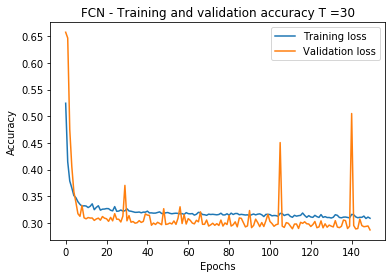

In [ ]:
acc = history.history['loss']
val_acc = history.history['val_loss']

plt.plot(np.arange(len(history.history['accuracy'])), acc, label='Training loss')
plt.plot(np.arange(len(history.history['accuracy'])), val_acc,label='Validation loss')
plt.title('FCN - Training and validation accuracy T ='+str(T))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the ANDI challenge, the rank of task 2 is evaluated with the F1 score. Let's see how well/bad we did (best value is 1). Recall that this is a toy example, as we are not considergin LW.

In [ ]:
from sklearn.metrics import f1_score

groundtruth = np.argmax(Y_e, axis = 1)
predictions = np.argmax(model.predict(X_e), axis = 1)

f1_score(groundtruth, predictions, average='micro')

0.7168055555555556

Not that bad! To analyze a bit more the predictions, we can use the confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(groundtruth, predictions)/(predictions.shape[0]/2)

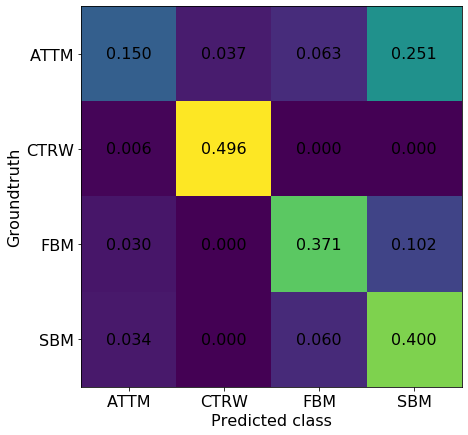

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
ax.matshow(conf)
for (i, j), z in np.ndenumerate(conf):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', fontsize = 16)
ax.set_xticklabels(['c','ATTM','CTRW','FBM','SBM'], fontsize = 16)
ax.set_yticklabels(['a','ATTM','CTRW','FBM','SBM'], fontsize = 16)
ax.set_xlabel('Predicted class', fontsize = 16)
ax.set_ylabel('Groundtruth', fontsize = 16)
ax.xaxis.set_ticks_position('bottom') 

We see here that the method is not perfect. For instance, it has a very hard time correctly classifying trajectories ATTM trajectories. For CTRW, the job is easier! Take into account that here we are working with trajectories without noise, contrary to what we have in the Challenge. 

### Now you are ready to use your favourite ML architecture on the true ANDI dataset! Can you do better?